In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns



In [3]:
import json

# Load API key from a JSON file
with open("../../config.json", "r") as file:
    config = json.load(file)

api_key = config["api_key"]


In [3]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join('/Users/aparnaambarapu/Downloads/qts/HW/HW1')
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )




In [4]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Data file /Users/aparnaambarapu/Downloads/qts/HW/HW1/AR/IVM_20250115.zip size 323894877 exists already, no need to download


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


In [5]:
t_ivm.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2',
       'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money',
       'days_expiration', 'days_termination'],
      dtype='object')

### DATA

Obtain second month futures prices from the Quandl OWF database for two pair CBT.FV, CBT.TY × 0.9524; CBT.W, NYX.T × 3.3586 for 3 Dec 2021 though 31 Aug 2024. Form the spreads. Student ID unique digits are 4,9

For all analysis below where ever specified s1/spread1 is 'CBT_FV - CBT_TY × 0.9524' and s2/spread2 is 'CBT.W - NYX.T × 3.3586'

In [6]:
t_ivm['date'] = pd.to_datetime(t_ivm['date'])

In [7]:
t_ivm.head()

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


In [8]:
def prepare_data(data, start_date, end_date, required_codes, drop_cols=True, cols=None):
    data['exchange_futures'] = data['exchange_code'] + '_' + data['futures_code']
    data['date'] = pd.to_datetime(data['date'])

    filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
    filtered_data = filtered_data[filtered_data['days_termination'] > 30]
    filtered_data = filtered_data[filtered_data['exchange_futures'].isin(required_codes)]
    filtered_data = (filtered_data
                     .sort_values(['days_termination'])
                     .groupby(['exchange_futures','date']).first().reset_index())
    if drop_cols:
        filtered_data = filtered_data[cols]
    return filtered_data

In [9]:
cols = ['exchange_futures', 'date', 'exchange_code', 'futures_code', 'expiration', 'futures', 'days_termination']
data = prepare_data(t_ivm, start_date='2021-12-03', end_date='2024-08-31', required_codes = [ 'CBT_FV', 'CBT_TY', 'CBT_W', 'NYX_T'], cols=cols)

In [10]:
data = data.set_index('date')

In [11]:
data.head()

,exchange_futures,exchange_code,futures_code,expiration,futures,days_termination
date,,,,,,
2021-12-03,CBT_FV,CBT,FV,1M,121.484375,31.0
2021-12-06,CBT_FV,CBT,FV,1M,121.054688,31.0
2021-12-07,CBT_FV,CBT,FV,1M,120.820312,31.0
2021-12-08,CBT_FV,CBT,FV,1M,120.796875,31.0
2021-12-09,CBT_FV,CBT,FV,1M,120.796875,31.0


In [12]:
cbt_fv_df = data[data['exchange_futures'] == 'CBT_FV']
cbt_ty_df = data[data['exchange_futures'] == 'CBT_TY']
cbt_w_df = data[data['exchange_futures'] == 'CBT_W']
nyx_t_df = data[data['exchange_futures'] == 'NYX_T']

In [13]:
cbt_w_df.head()

,exchange_futures,exchange_code,futures_code,expiration,futures,days_termination
date,,,,,,
2021-12-03,CBT_W,CBT,W,1M,797.166667,31.0
2021-12-06,CBT_W,CBT,W,1M,800.666667,31.0
2021-12-07,CBT_W,CBT,W,1M,803.537500,31.0
2021-12-08,CBT_W,CBT,W,1M,789.614583,31.0
2021-12-09,CBT_W,CBT,W,1M,770.741667,31.0


In [14]:
col_name = 'futures'
spread1 = ((cbt_ty_df[col_name] * 0.9524) - cbt_fv_df[col_name]).to_frame('spread')
spread2 = ((nyx_t_df[col_name] * 3.3586) - cbt_w_df[col_name]).to_frame('spread')

In [15]:
spread2.head()

,spread
date,
2021-12-03,-35.345339
2021-12-06,-38.608586
2021-12-07,-43.695544
2021-12-08,-34.675633
2021-12-09,-19.075975


In [16]:
def check_spread_values(df, checks):
    all_checks_passed = True

    for date, expected_spread in checks.items():
        if date in df.index:
            actual_spread = df.loc[date, 'spread']
            if abs(actual_spread-expected_spread) > 1e-6:
                print(f"Check failed for date {date}: Expected {expected_spread}, Found {actual_spread}")
                all_checks_passed = False
        else:
            print(f"Check failed for date {date}: Date not found in data.")
            all_checks_passed = False

    # Final summary
    if all_checks_passed:
        print("All checks passed successfully!")
    else:
        print("Some checks failed. Please review the error messages.")

In [17]:
check_spread_values(spread1, checks = {'2024-02-16':-1.989725, '2024-02-19': -1.822434})

All checks passed successfully!


In [18]:
check_spread_values(spread2, checks = {'2024-04-12': 30.663455, '2024-04-15': 29.016927})

All checks passed successfully!


All given checks passed by the calculated spread data


## Analysis
### Individual Dynamics
- Spread vs date
- Spread distribution
- Spread Summary statistics
- Difference of Spread and N-day rolling average of spread for N = 10, 20, 50, 100 plots and their Summary statistics
#### spread 1: CBT_FV - CBT_TY × 0.9524, spread2: CBT.W - NYX.T × 3.3586


In [19]:
spread1['type'] = 'CBT_FV - CBT_TY × 0.9524'
spread2['type'] = 'CBT.W - NYX.T × 3.3586'
combined_data = pd.concat([spread1, spread2]).reset_index()

In [20]:
combined_data.head()

,date,spread,type
0,2021-12-03,4.017710,CBT_FV - CBT_TY × 0.9524
1,2021-12-06,3.676679,CBT_FV - CBT_TY × 0.9524
2,2021-12-07,3.594623,CBT_FV - CBT_TY × 0.9524
3,2021-12-08,3.495086,CBT_FV - CBT_TY × 0.9524
4,2021-12-09,3.646188,CBT_FV - CBT_TY × 0.9524


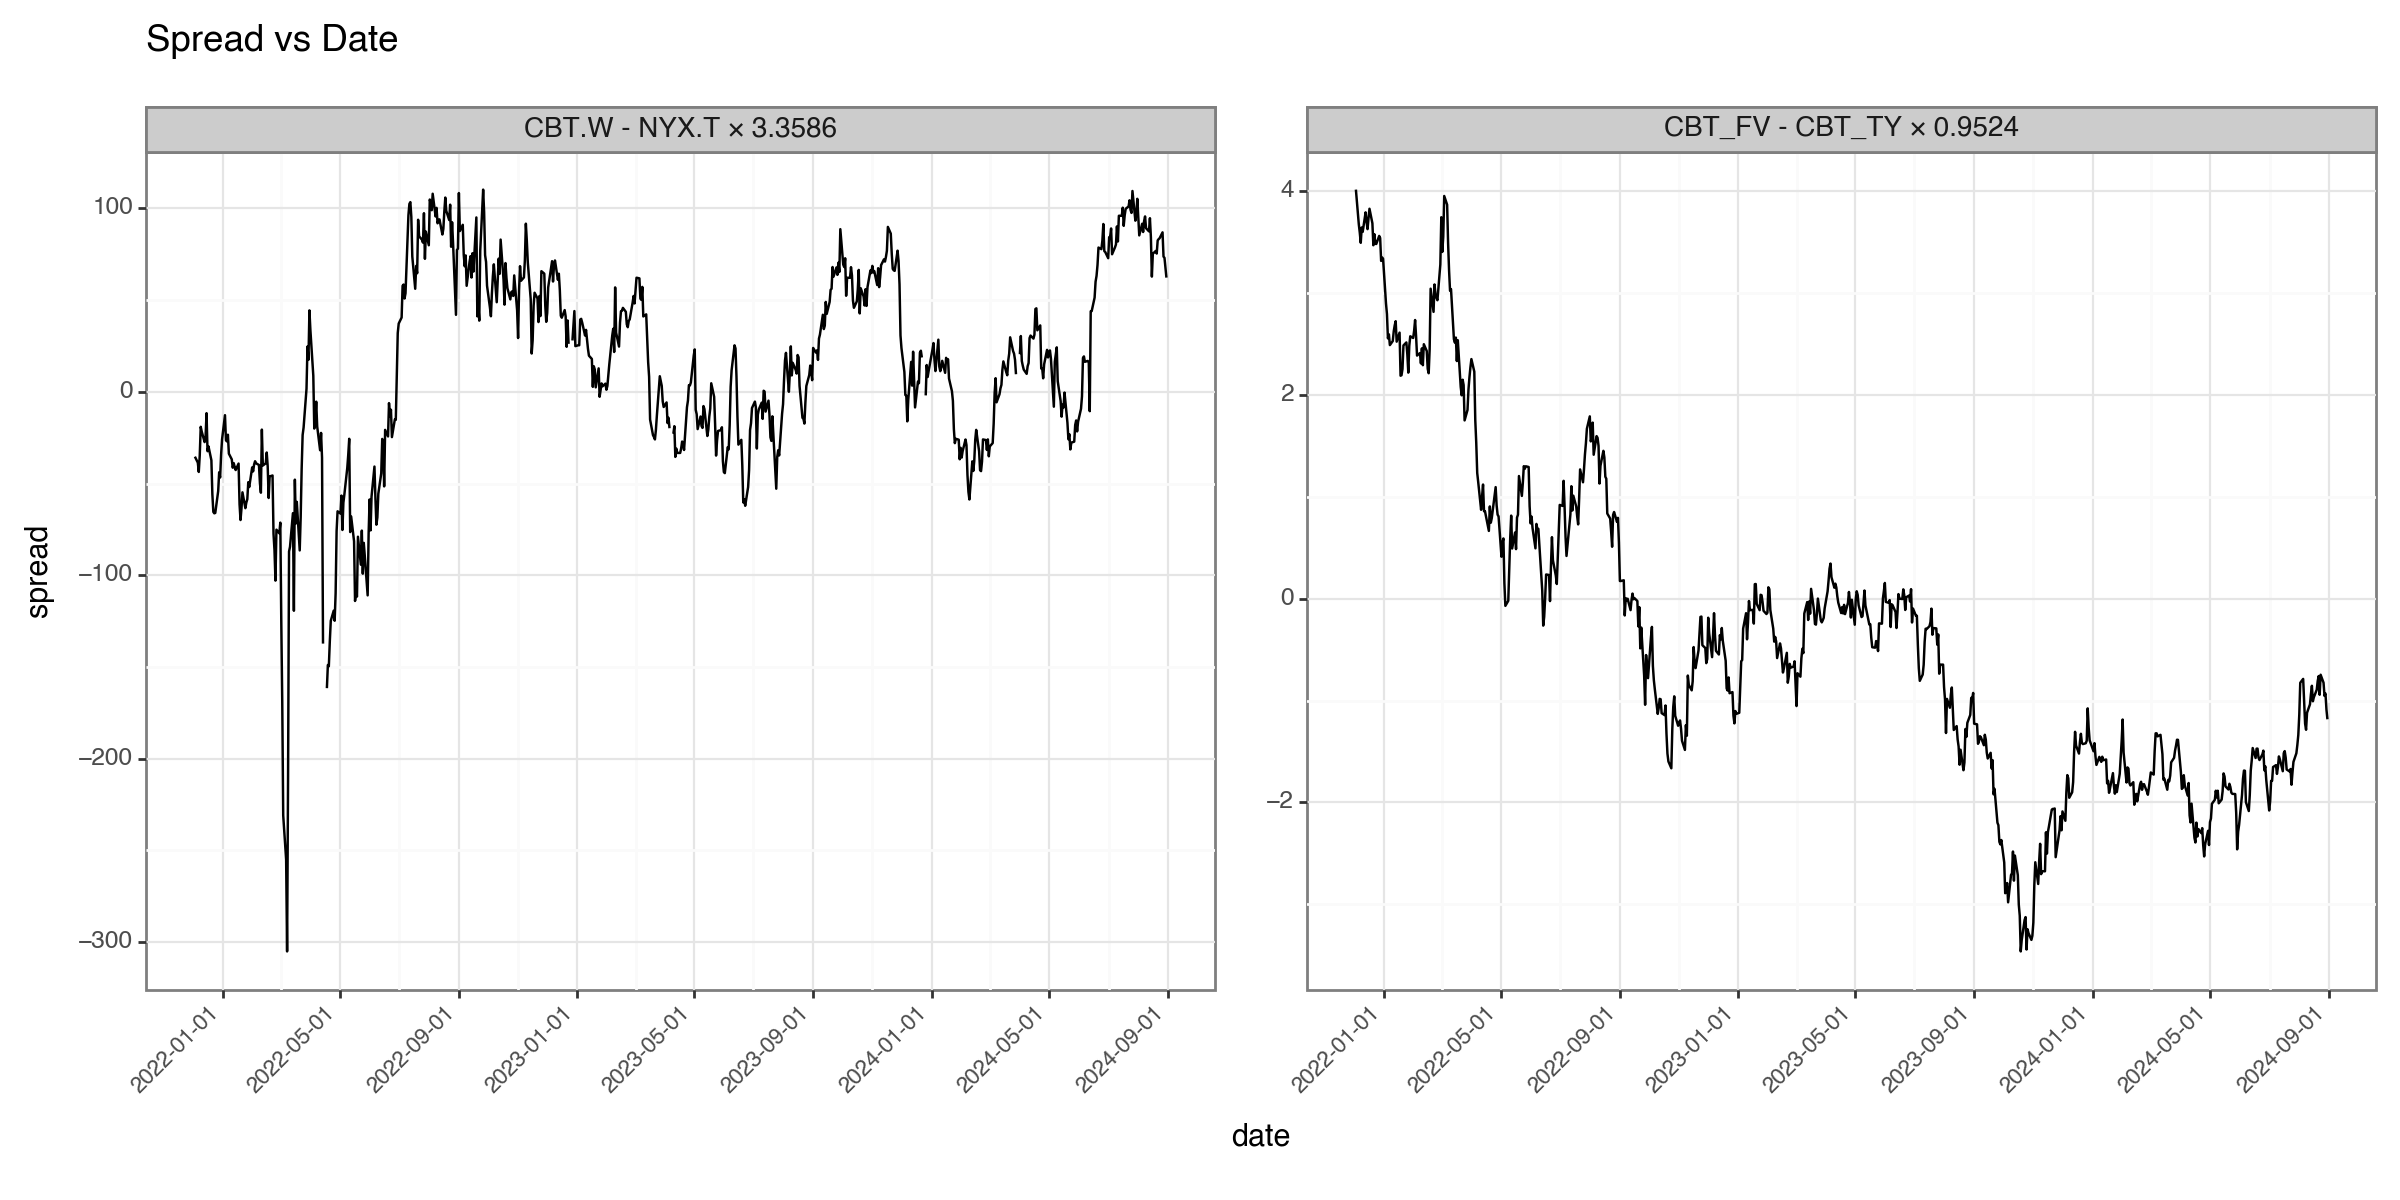

In [21]:
p = (p9.ggplot(combined_data, p9.aes(x='date', y='spread'))
     + p9.geom_line()
     + p9.facet_wrap('~type', scales='free_y')
     + p9.ggtitle("Spread vs Date")
     + p9.theme_bw()
     + p9.theme(axis_text_x=p9.element_text(rotation=45, ha='right', size=8),
             figure_size=(12, 6),
             strip_text_x=p9.element_text(size=10))
)
print(p)

/opt/anaconda3/envs/quandl/lib/python3.8/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.


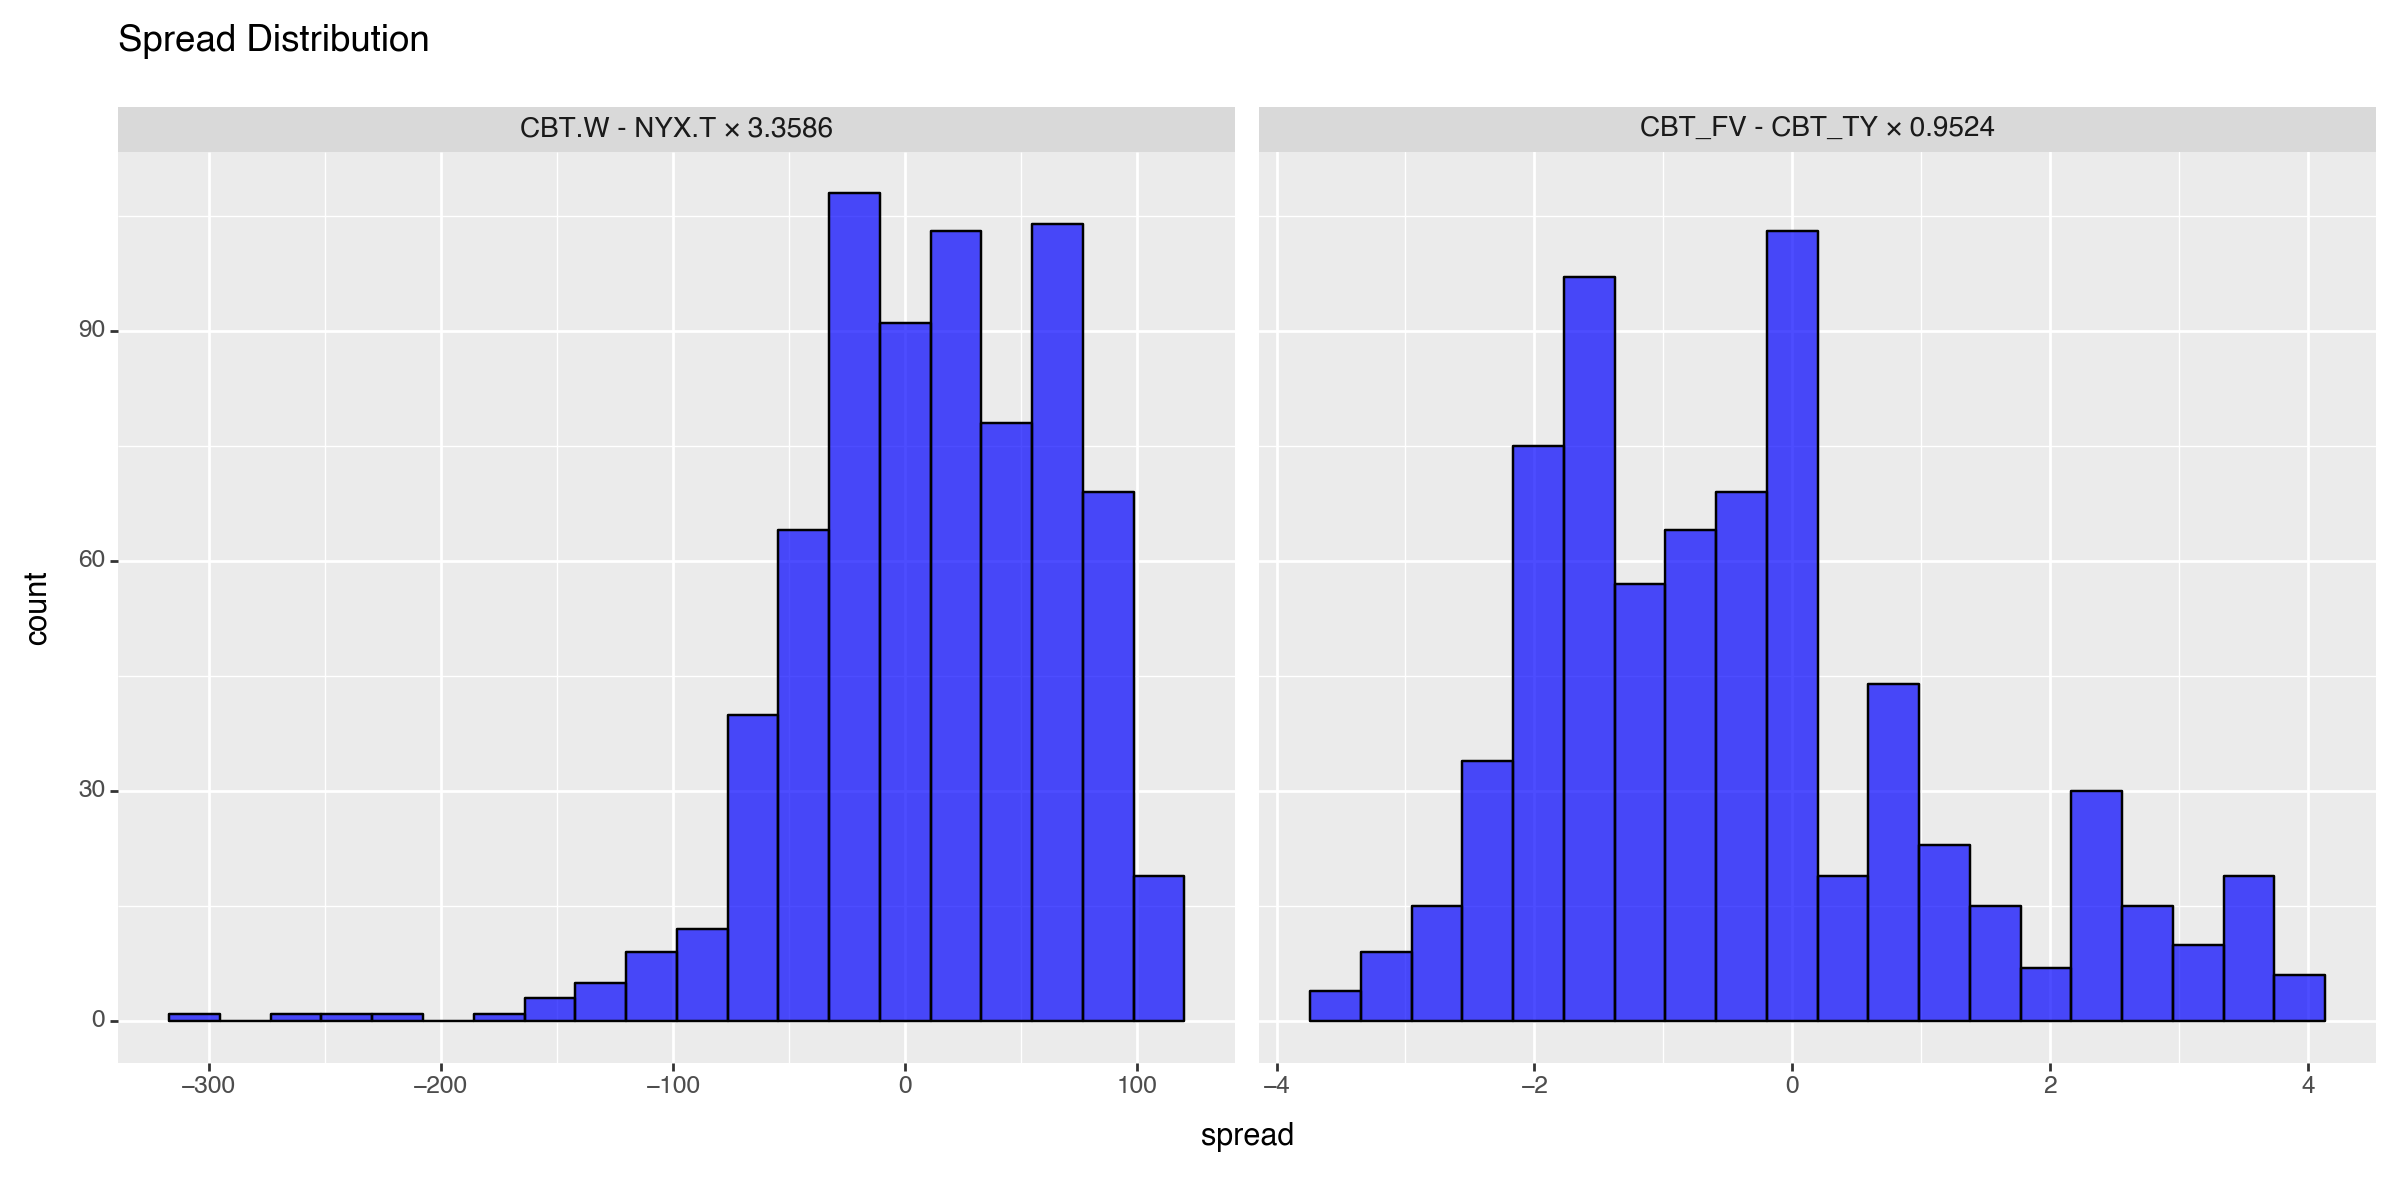

In [22]:
p = (p9.ggplot(combined_data, p9.aes(x='spread'))
     + p9.geom_histogram(bins=20, fill='blue', color='black', alpha=0.7)
     + p9.facet_wrap('~type', scales='free_x')
     + p9.ggtitle("Spread Distribution")
          + p9.theme(figure_size=(12, 6),
             strip_text_x=p9.element_text(size=10))
)

print(p)

In [23]:
def summary_stats(df, col_name='spread', type=None):
    if type:
        filter_df = df[df['type']==type][col_name]
    else:
        filter_df = df.copy()[col_name]
    summ_df = filter_df.describe().to_frame().T
    summ_df['Skewness'] = round(filter_df.skew(),2)
    summ_df['Excess Kurtosis'] = round(filter_df.kurtosis(),2)
    summ_df['VaR (0.05)']=round(filter_df.quantile(0.05), 2)
    return summ_df


In [27]:
summary_stats(combined_data,type='CBT.W - NYX.T × 3.3586') ## missing

,count,mean,std,min,25%,50%,75%,max,Skewness,Excess Kurtosis,VaR (0.05)
spread,710.0,12.039852,56.443679,-305.118729,-25.82499,14.462893,57.0749,110.2475,-0.83,2.1,-75.83


In [28]:
summary_stats(combined_data,type='CBT_FV - CBT_TY × 0.9524')

,count,mean,std,min,25%,50%,75%,max,Skewness,Excess Kurtosis,VaR (0.05)
spread,715.0,-0.369163,1.596718,-3.463422,-1.584469,-0.573588,0.393607,4.01771,0.77,0.09,-2.41


- Spread 1 is riskier due to its higher variability (std), wider range, heavier tails, and larger downside risk (VaR). It may be suitable for high-risk, high-reward strategies but requires careful risk management.
- Spread 2 is more stable, with a much tighter range, lower variability, and near-normal distribution. It's better suited for strategies requiring consistency and predictability.

In [35]:
def rolling_average_diff(spread, N_list, col_name):
    df = spread.copy()
    result_df = pd.DataFrame(index=spread.index)
    for N in N_list:
        df['Rolling_Avg'] = df[col_name].rolling(window=N).mean()
        df[f'Diff_{N}'] = df[col_name] - df['Rolling_Avg']
        result_df[f'Diff_{N}'] = df[f'Diff_{N}'].dropna()
    return result_df.dropna()


In [36]:
s1_diff = rolling_average_diff(spread1, [10,20,50,100], 'spread')

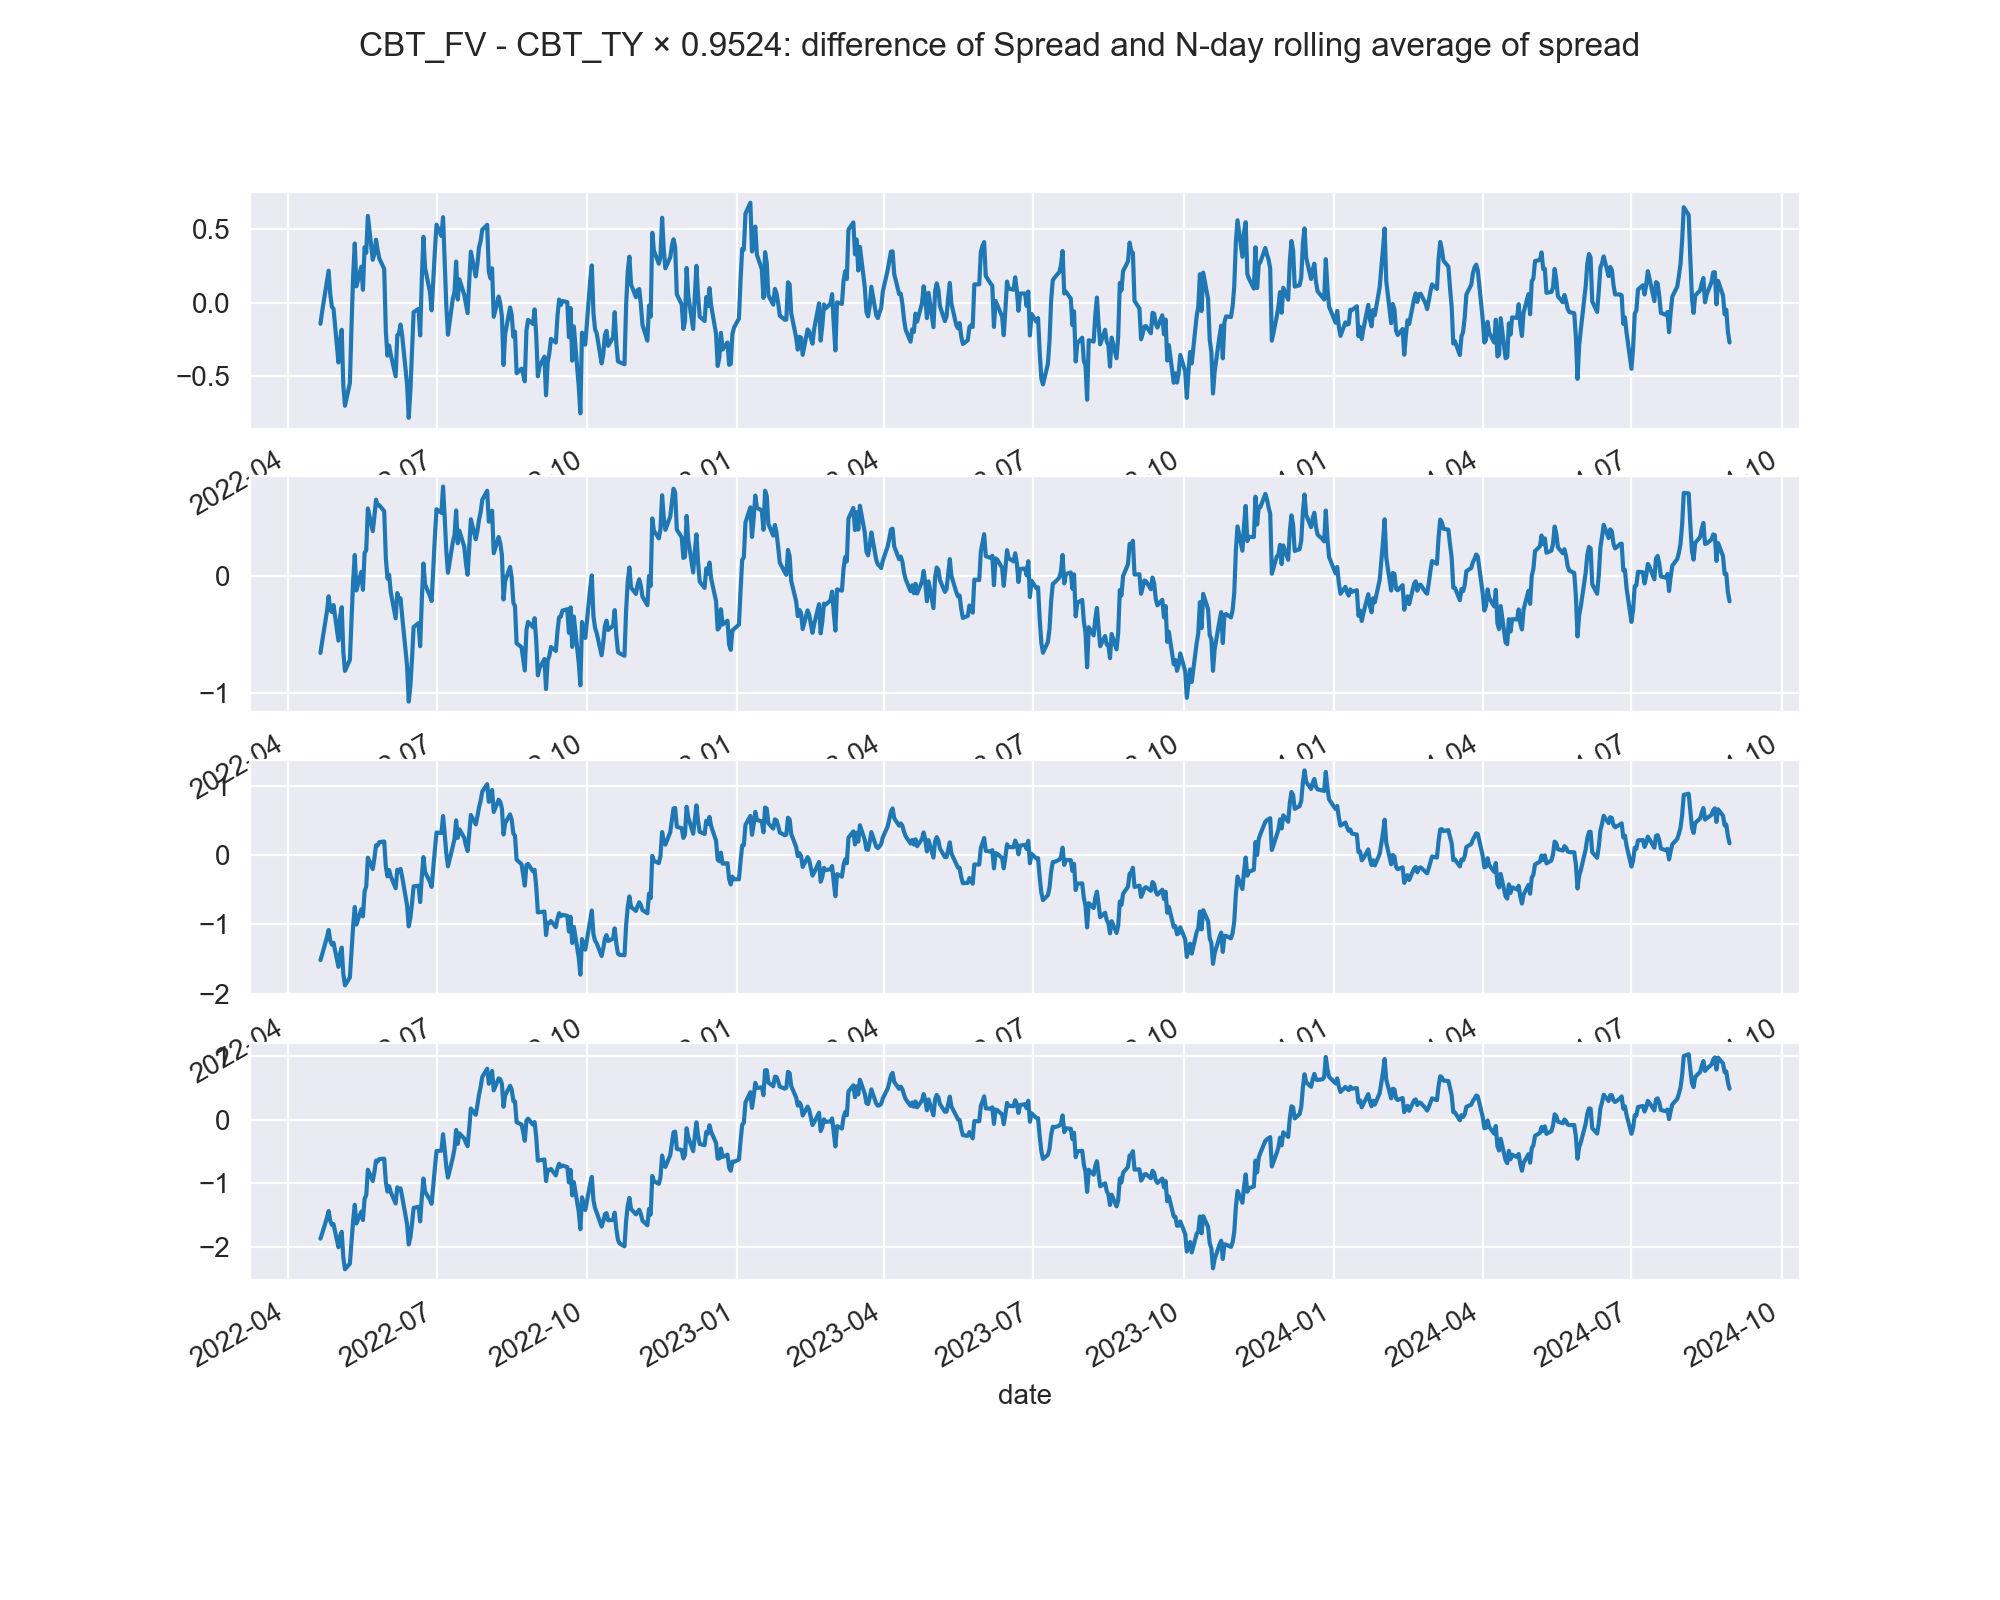

In [37]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize = (10,8))

s1_diff['Diff_10'].plot(ax=axes[0])
s1_diff['Diff_20'].plot(ax=axes[1])
s1_diff['Diff_50'].plot(ax=axes[2])
s1_diff['Diff_100'].plot(ax=axes[3])

fig.suptitle("CBT_FV - CBT_TY × 0.9524: difference of Spread and N-day rolling average of spread");
plt.show()

### Key Insights:
1. **Mean Reversion Behavior**: The fluctuations around zero in all subplots suggest mean-reverting tendencies in the spread, indicating potential opportunities for statistical arbitrage.

2. **Volatility Patterns**:
   - The top subplot shows higher frequency and smaller amplitude oscillations, suggesting a shorter rolling window or less smoothing.
   - Lower subplots display progressively smoother and larger oscillations, indicating longer rolling windows or more significant averaging effects.

3. **Trend Shifts**: Around mid-2023, the spread appears to shift towards more pronounced deviations from zero in the lower subplots, possibly reflecting a structural change in market conditions or relationships between CBT_FV and CBT_TY.

4. **Seasonality or Cyclicality**: Regular peaks and troughs suggest a potential cyclical pattern in the spread dynamics, which could be exploited for predictive purposes.


In [40]:
s2_diff = rolling_average_diff(spread2, [10,20,50,100], 'spread')

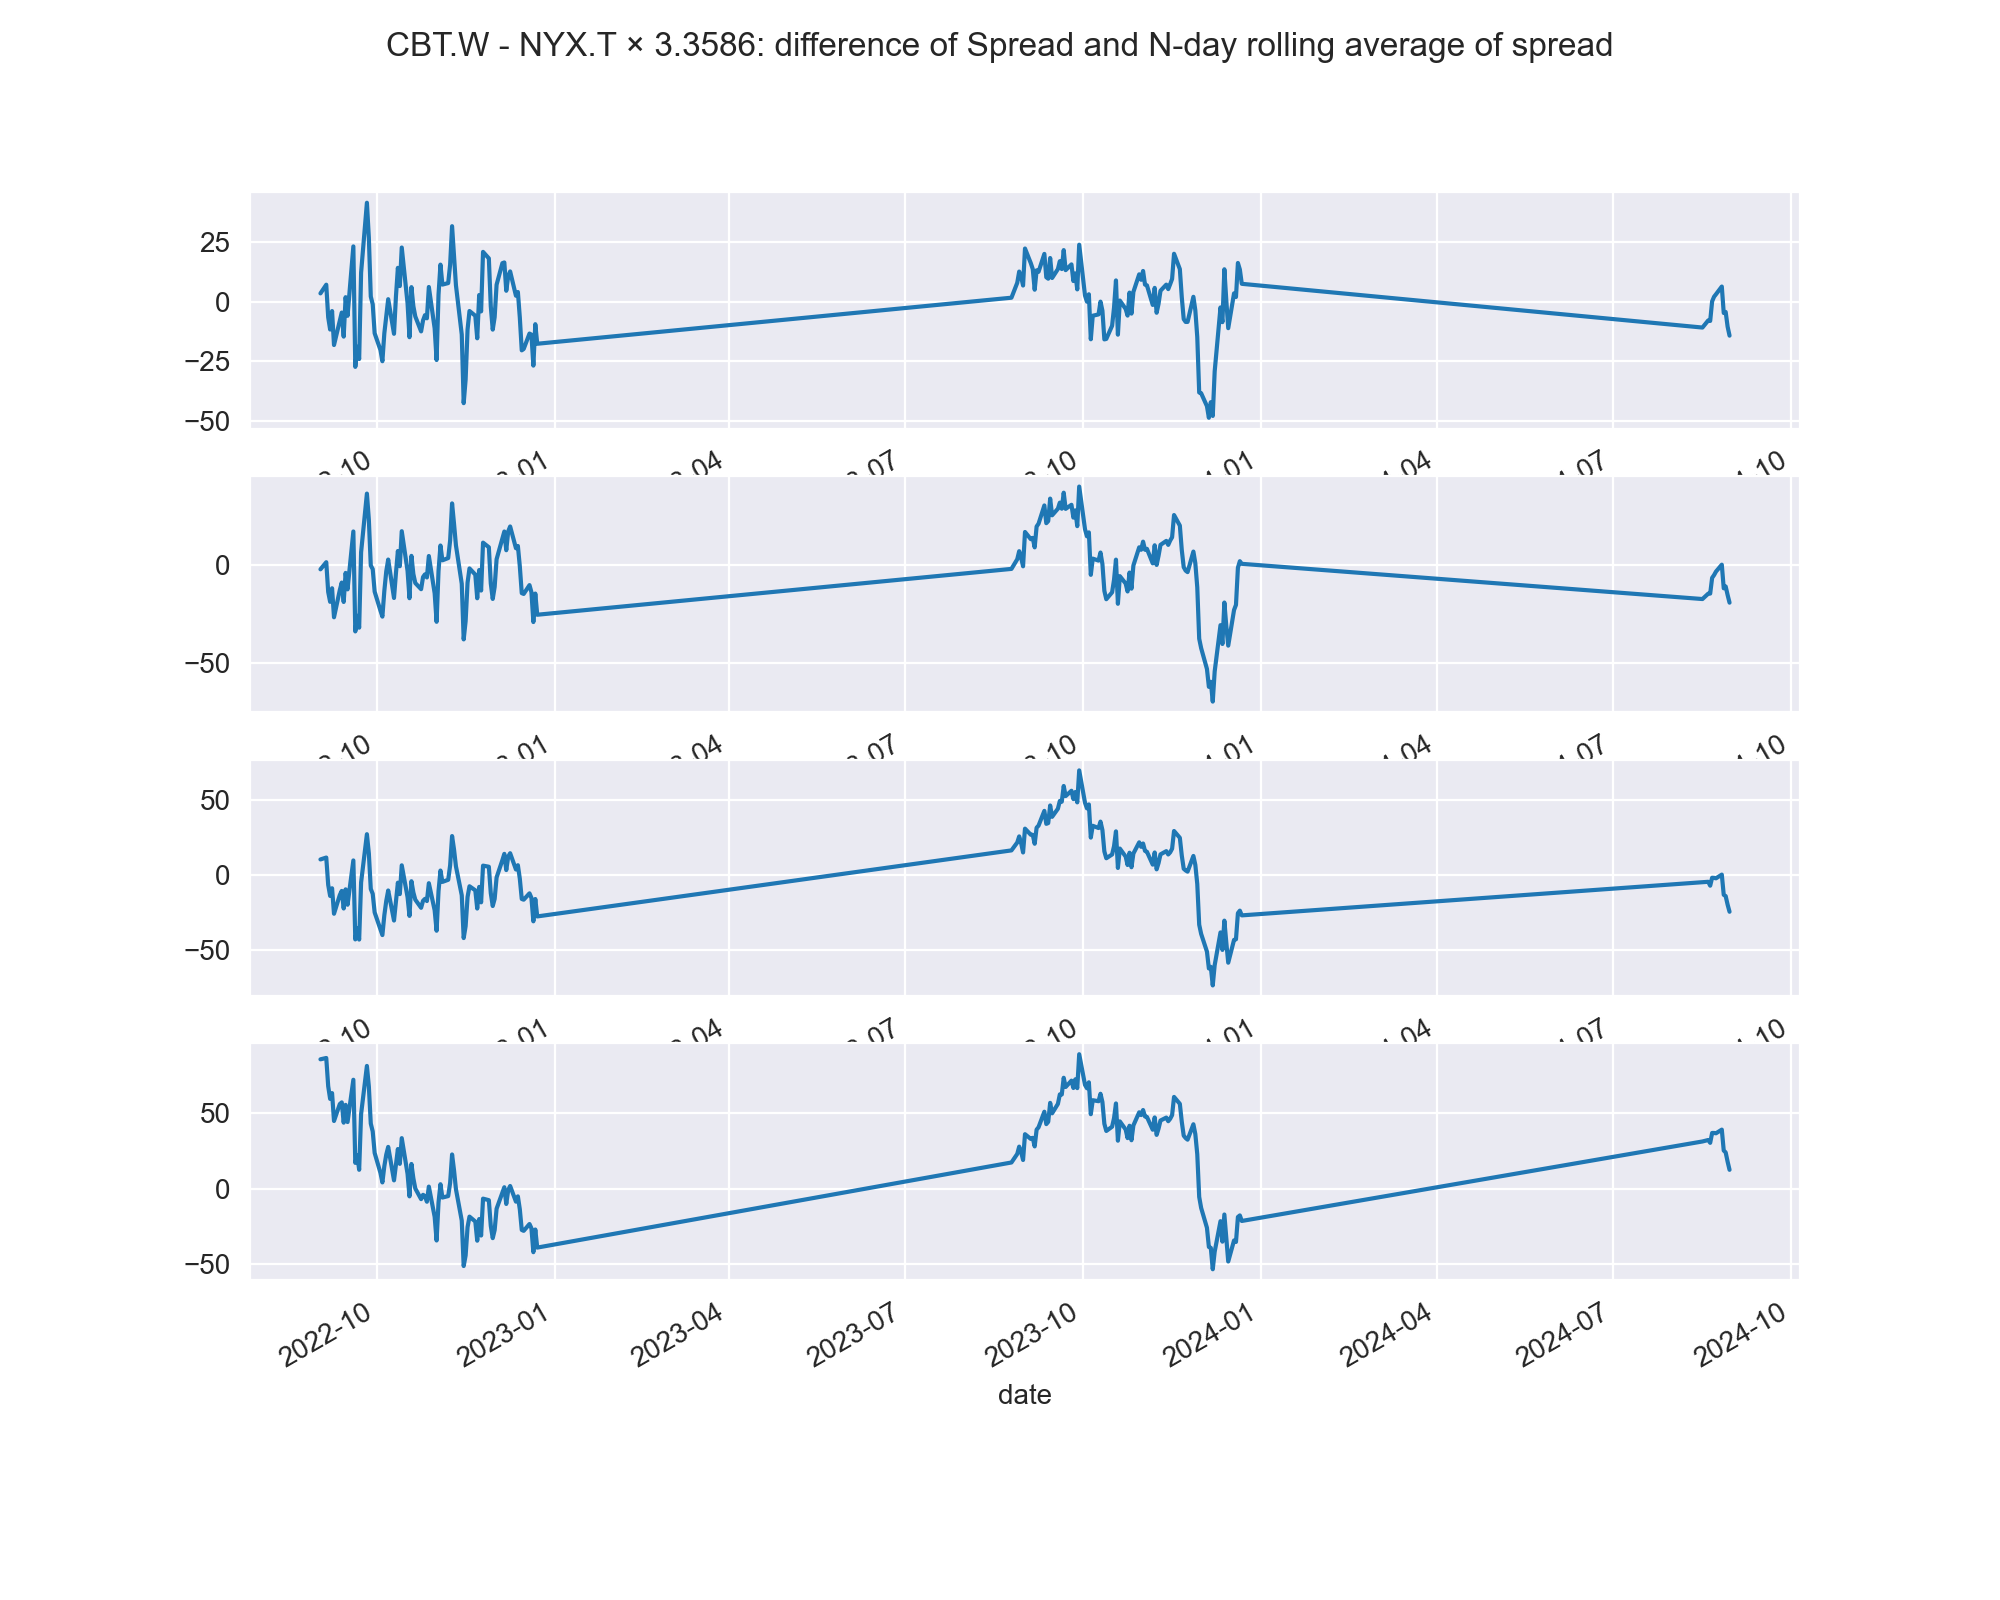

In [41]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize = (10,8))

s2_diff['Diff_10'].plot(ax=axes[0])
s2_diff['Diff_20'].plot(ax=axes[1])
s2_diff['Diff_50'].plot(ax=axes[2])
s2_diff['Diff_100'].plot(ax=axes[3])

fig.suptitle("CBT.W - NYX.T × 3.3586: difference of Spread and N-day rolling average of spread");
plt.show()

- Structural Shift: Around early 2023, the spread undergoes a significant transition from oscillatory behavior to a pronounced upward trend, indicating a potential change in the relationship between CBT.W and NYX.T.
- Volatility Dynamics:
    - Pre-2023: High-frequency fluctuations with mean-reverting tendencies dominate.
    - Post-2023: Volatility decreases as the spread trends upward, showing less oscillation around zero.

In [42]:
pd.concat([summary_stats(s1_diff, 'Diff_10'), summary_stats(s1_diff, 'Diff_20'), summary_stats(s1_diff, 'Diff_50'), summary_stats(s1_diff, 'Diff_100')], axis=0)

,count,mean,std,min,25%,50%,75%,max,Skewness,Excess Kurtosis,VaR (0.05)
Diff_10,616.0,-0.013342,0.257351,-0.782714,-0.190848,-0.016531,0.157870,0.680876,-0.02,-0.16,-0.43
Diff_20,616.0,-0.032628,0.370747,-1.076146,-0.288981,-0.028411,0.240666,0.770744,-0.16,-0.46,-0.66
Diff_50,616.0,-0.122141,0.593594,-1.882829,-0.461869,-0.037577,0.301442,1.221756,-0.53,-0.18,-1.25
Diff_100,616.0,-0.299603,0.767187,-2.348991,-0.802849,-0.108448,0.286913,1.027913,-0.63,-0.51,-1.77


In [43]:
pd.concat([summary_stats(s2_diff, 'Diff_10'), summary_stats(s2_diff, 'Diff_20'), summary_stats(s2_diff, 'Diff_50'), summary_stats(s2_diff, 'Diff_100')], axis=0)

,count,mean,std,min,25%,50%,75%,max,Skewness,Excess Kurtosis,VaR (0.05)
Diff_10,178.0,-0.988996,15.219896,-48.710781,-9.219205,0.797892,9.128517,41.534519,-0.64,1.00,-27.63
Diff_20,178.0,-2.424973,19.598607,-69.398456,-13.546699,-1.741059,10.094216,40.033082,-0.54,0.84,-37.44
Diff_50,178.0,0.190098,27.348085,-73.586505,-16.942556,-0.600599,16.423655,69.872173,-0.03,-0.18,-43.02
Diff_100,178.0,20.573061,34.379935,-53.234468,-6.842729,27.662568,46.470046,88.781294,-0.26,-0.95,-35.70


### Comparative Analysis
- Spreads Correlation
- Differences Correlation

In [44]:
print('Correlation between spreads')
(pd.merge(spread1, spread2, on='date')[['spread_x', 'spread_y']]
 .rename(columns={'spread_x':'CBT_FV - CBT_TY × 0.9524', 'spread_y':'CBT.W - NYX.T × 3.3586'}).corr())

Correlation between spreads


,CBT_FV - CBT_TY × 0.9524,CBT.W - NYX.T × 3.3586
CBT_FV - CBT_TY × 0.9524,1.000000,-0.472929
CBT.W - NYX.T × 3.3586,-0.472929,1.000000


The two spreads exhibit a moderate negative correlation (-0.4729), indicating that as one spread increases, the other tends to decrease. This relationship could highlight hedging potential or market dynamics between the underlying instruments. Understanding this inverse relationship can help refine trading or risk management strategies.

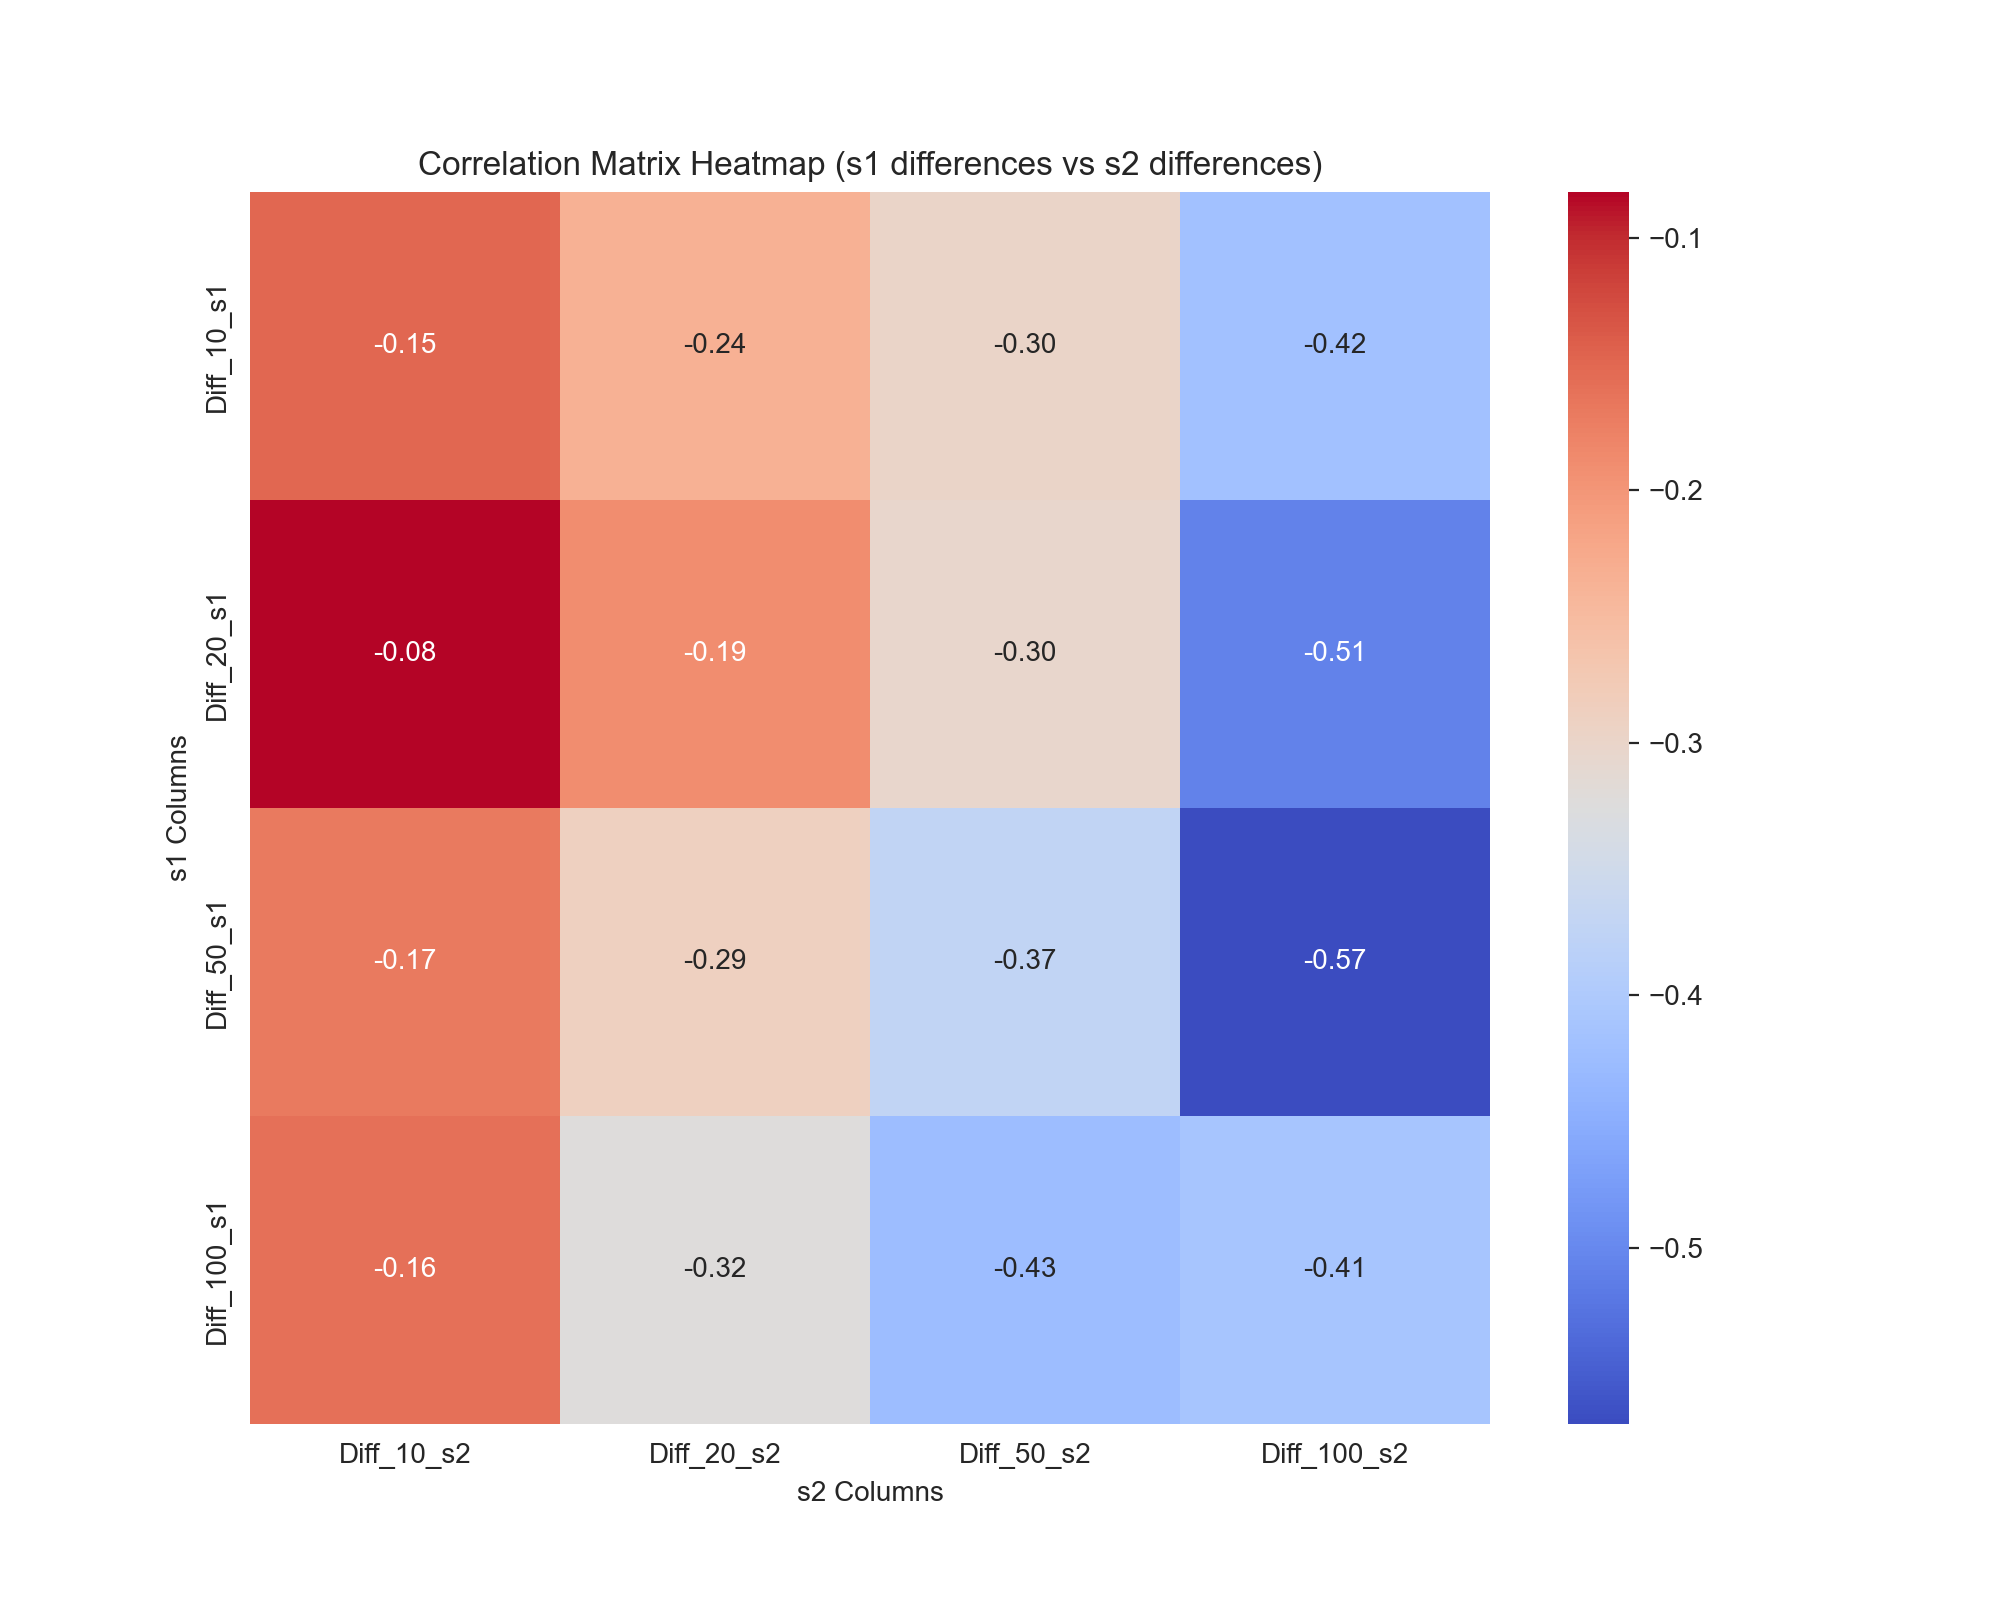

In [45]:
merged_data = pd.merge(s1_diff, s2_diff, left_index=True, right_index=True)
merged_data.columns = [col.replace('_x', '_s1').replace('_y', '_s2') for col in merged_data.columns]
s1_columns = [col for col in merged_data.columns if '_s1' in col]
s2_columns = [col for col in merged_data.columns if '_s2' in col]

correlation_matrix = pd.DataFrame(
    [[merged_data[col1].corr(merged_data[col2]) for col2 in s2_columns] for col1 in s1_columns],
    index=s1_columns,
    columns=s2_columns
)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap (s1 differences vs s2 differences)")
plt.xlabel("s2 Columns")
plt.ylabel("s1 Columns")
plt.show()

The heatmap reveals a systematic inverse relationship between the deviations (`Diff_N`) of spreads in `s1` and `s2`.

- Stronger correlations for larger N (e.g., `Diff_50`, `Diff_100`) suggest that long-term deviations from rolling averages are more aligned inversely, indicating potential for mean-reversion or hedging strategies.
- Weaker correlations for smaller N (e.g., `Diff_10`, `Diff_20`) imply that short-term deviations are less related, possibly driven by independent volatility or noise.